# External Dependencies
<br>  

### References
- [jqassistant](https://jqassistant.org)
- [Neo4j Python Driver](https://neo4j.com/docs/api/python-driver/current)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plot
from neo4j import GraphDatabase

In [2]:
# Please set the environment variable "NEO4J_INITIAL_PASSWORD" in your shell 
# before starting jupyter notebook to provide the password for the user "neo4j". 
# It is not recommended to hardcode the password into jupyter notebook for security reasons.

driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD")))
driver.verify_connectivity()

In [3]:
def get_cypher_query_from_file(filename):
    with open(filename) as file:
        return ' '.join(file.readlines())

In [4]:
def query_cypher_to_data_frame(filename):
    records, summary, keys = driver.execute_query(get_cypher_query_from_file(filename))
    return pd.DataFrame([r.values() for r in records], columns=keys)

In [5]:
#The following cell uses the build-in %html "magic" to override the CSS style for tables to a much smaller size.
#This is especially needed for PDF export of tables with multiple columns.

In [6]:
%%html
<style>
/* CSS style for smaller dataframe tables. */
.dataframe th {
    font-size: 8px;
}
.dataframe td {
    font-size: 8px;
}
</style>

In [7]:
# Main Colormap
main_color_map = 'nipy_spectral'

## External Package Usage

### External Package

An external type has no `byteCodeVersion` since it only occurs as a dependency but wasn't analyzed itself (missing bytecode). Core Java types like `java.lang.Integer` and primitives like `int` are considered "build-in" and therefore aren't interpreted as "external" even though their byte code is also missing. A package is categorized as "external" if the types it contains are classified as external.

### External annotation dependency

The aforementioned classification encompasses external annotation dependencies as well. These dependencies introduce significantly less coupling and are not indispensable for compiling code. Without the external annotation the code would most probably behave differently. Hence, they are included in the first more overall and general tables and then left out in the later more specific ones.

### Table 1 - Top 20 most used external packages overall

This table shows the external packages that are used by the most different internal types overall.
Additionally, it shows which types of the external package are actually used. External annotations are also listed.

Only the top 20 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_overall`

**Columns:**
- *externalPackageName* identifies the external package as described above
- *numberOfExternalCallerPackages* refers to the distinct packages that make use of the external package
- *numberOfExternalCallerTypes* refers to the distinct types that make use of the external package
- *numberOfExternalTypeCalls* includes every dependency to the types in the external package
- *numberOfExternalTypeCallsWeighted* includes every invocation or reference (sum of weights) to the types in the external package
- *allPackages* contains the total count of all analyzed packages in general
- *allTypes* contains the total count of all analyzed types in general
- *externalTypeNames* contains a list of actually utilized types of the external package

In [8]:
external_package_usage=query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_overall.cypher")

# Select columns and only show the first 20 entries (head)
external_package_usage.head(20)

,externalPackageName,numberOfExternalCallerPackages,numberOfExternalCallerTypes,numberOfExternalTypeCalls,numberOfExternalTypeCallsWeighted,allPackages,allTypes,tenExternalTypeNames
0,javax.annotation,76,342,374,1729,114,1436,"[Nonnull, Nullable, PreDestroy]"
1,org.slf4j,66,141,253,713,114,1436,"[LoggerFactory, Logger]"
2,javax.persistence,15,27,82,311,114,1436,"[LockModeType, EntityManager, Lob, MappedSuper..."
3,com.fasterxml.jackson.annotation,13,23,57,87,114,1436,"[JsonCreator, JsonProperty, JsonTypeInfo, Json..."
4,jakarta.persistence,10,25,73,299,114,1436,"[EntityManager, LockModeType, Basic, Lob, Colu..."
5,io.axoniq.axonserver.grpc,7,30,55,273,114,1436,"[ErrorMessage, ErrorMessage$Builder, Instructi..."
6,io.axoniq.axonserver.connector,6,21,30,126,114,1436,"[AxonServerConnectionFactory, AxonServerConnec..."
7,org.hamcrest,5,27,59,370,114,1436,"[CoreMatchers, Matcher, StringDescription, Des..."
8,io.grpc,4,12,50,94,114,1436,"[ManagedChannelBuilder, Channel, ClientInterce..."
9,reactor.core.publisher,4,27,49,198,114,1436,"[SignalType, Flux, BaseSubscriber, Mono, FluxS..."


#### Table 1 Chart 1 - Most called external packages in % by types

External packages that are used less than 0.7% are grouped into the name "others" to get a cleaner chart
with the most significant external packages and how ofter they are called in percent.

In [9]:
def group_to_others_below_threshold(data_frame : pd.DataFrame, value_column : str, name_column: str, threshold: float) -> pd.DataFrame:    
    """Adds a new percentage column for the value column and 
    groups all values below the given threshold to "others" in the name column.

    Parameters:
    - data_frame (pd.DataFrame): Input pandas DataFrame
    - value_column (str): Name of the column that contains the numeric value
    - name_column (str): Name of the column that contains the group name that will be replaced by "others" for small values
    - threshold (float): Threshold in % that is used to group values below it into the "others" group

    Returns:
    int:Returning value

    """
    result_data_frame = data_frame.copy();

    percent_column_name = value_column + 'Percent';

    # Add column with the name given in "percent_column_name" with the percentage of the value column.
    result_data_frame[percent_column_name] = result_data_frame[value_column] / result_data_frame[value_column].sum() * 100.0;

    # Change the external package name to "others" if it is called less than the specified threshold
    result_data_frame.loc[result_data_frame[percent_column_name] < threshold, name_column] = 'others';

    # Group external package name (foremost the new "others" entries) and sum their percentage
    result_data_frame = result_data_frame.groupby(name_column)[percent_column_name].sum();

    # Sort by values descending
    return result_data_frame.sort_values(ascending=False);

In [10]:
external_package_by_type_usage_significant = group_to_others_below_threshold(
    data_frame=external_package_usage,
    value_column='numberOfExternalCallerTypes',
    name_column='externalPackageName',
    threshold= 0.7
);

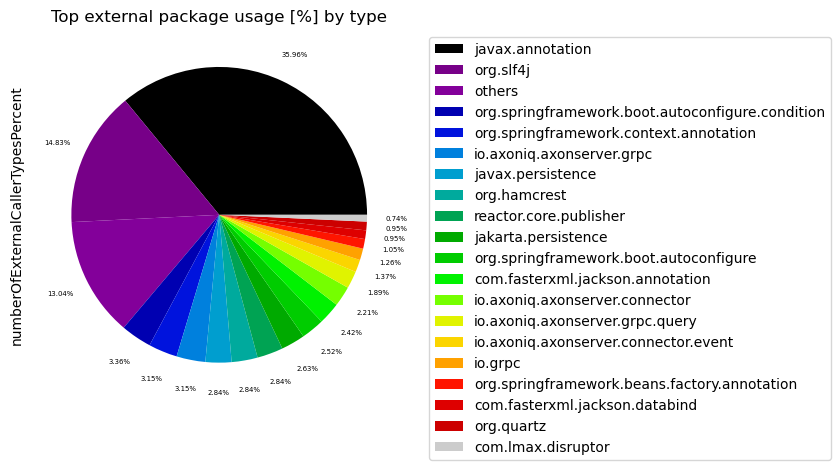

In [11]:
if external_package_by_type_usage_significant.empty:
    print("No data to plot")
else:
    plot.figure();

    axis = external_package_by_type_usage_significant.plot(
        kind='pie',
        title='Top external package usage [%] by type',
        legend=True,
        labeldistance=None,
        autopct='%1.2f%%',
        textprops={'fontsize': 5},
        pctdistance=1.2,
        cmap=main_color_map
    )
    axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot.show()

#### Table 1 Chart 2 - Most called external packages in % by packages

External packages that are used less than 0.7% are grouped into the name "others" to get a cleaner chart
with the most significant external packages and how ofter they are called in percent.

In [12]:
external_package_by_package_usage_significant = group_to_others_below_threshold(
    data_frame=external_package_usage,
    value_column='numberOfExternalCallerPackages',
    name_column='externalPackageName',
    threshold= 0.7
);

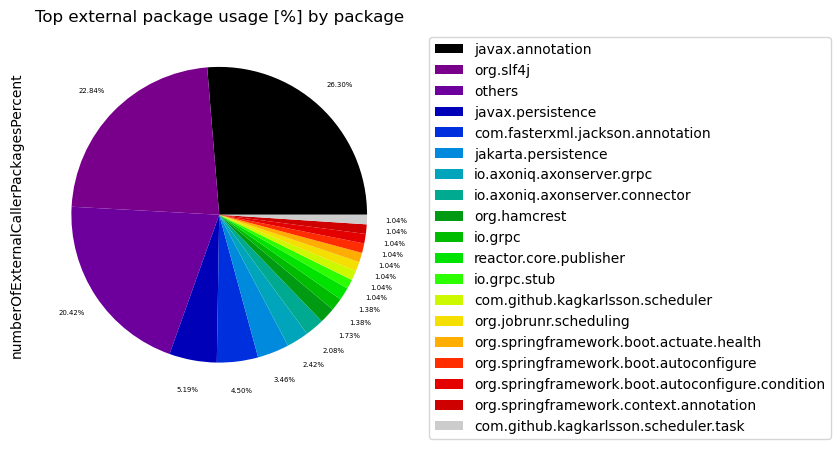

In [13]:
if external_package_by_package_usage_significant.empty:
    print("No data to plot")
else:
    plot.figure();

    axis = external_package_by_package_usage_significant.plot(
        kind='pie',
        title='Top external package usage [%] by package',
        legend=True,
        labeldistance=None,
        autopct='%1.2f%%',
        textprops={'fontsize': 5},
        pctdistance=1.2,
        cmap=main_color_map
    )
    axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot.show()

### Table 2 - Top 20 most used external packages grouped by their first 2 layers

This table shows external packages grouped by their first 2 layers that are used by the most different internal types overall including external annotations. For example, "javax.xml.stream" and "javax.xml.parsers" are grouped together to "javax.xml".

Additionally, it shows which types of the external packages are actually used.

Only the top 20 entries are shown. The whole table can be found in the following CSV report:
`External_second_level_package_usage_overall`

**Columns:**
- *externalSecondLevelPackageName* identifies the first 2 levels of the external package as described above
- *numberOfExternalCallerPackages* refers to the distinct packages that make use of the external package
- *numberOfExternalCallerTypes* refers to the distinct types that make use of the external package
- *numberOfExternalTypeCalls* includes every dependency to the types in the external package
- *numberOfExternalTypeCallsWeighted* includes every invocation or reference (sum of weights) to the types in the external package
- *allPackages* contains the total count of all analyzed packages in general
- *allTypes* contains the total count of all analyzed types in general
- *externalTypeNames* contains a list of actually utilized types of the external package

In [14]:
external_grouped_package_usage=query_cypher_to_data_frame("../cypher/External_Dependencies/External_second_level_package_usage_overall.cypher")
external_grouped_package_usage.head(20)

,externalSecondLevelPackageName,numberOfExternalCallerPackages,numberOfExternalCallerTypes,numberOfExternalTypeCalls,numberOfExternalTypeCallsWeighted,allPackages,allTypes,tenExternalTypeNames
0,javax.annotation,76,342,374,1729,114,1436,"[Nonnull, Nullable, PreDestroy]"
1,org.slf4j,66,141,253,713,114,1436,"[LoggerFactory, Logger]"
2,com.fasterxml,15,33,89,199,114,1436,"[JsonCreator, JsonProperty, JsonTypeInfo, Json..."
3,javax.persistence,15,27,82,311,114,1436,"[LockModeType, EntityManager, Lob, MappedSuper..."
4,jakarta.persistence,10,25,73,299,114,1436,"[EntityManager, LockModeType, Basic, Lob, Colu..."
5,io.axoniq,9,67,197,973,114,1436,"[NodeInfo, NodeInfo$Builder, ErrorMessage, Err..."
6,org.springframework,8,53,249,531,114,1436,"[ConfigurationProperties, Status, Health$Build..."
7,io.grpc,5,18,61,126,114,1436,"[ManagedChannelBuilder, StreamObserver, SslCon..."
8,org.hamcrest,5,27,59,370,114,1436,"[CoreMatchers, Matcher, StringDescription, Des..."
9,reactor.core,5,28,53,203,114,1436,"[Scheduler, Schedulers, SignalType, Flux, Base..."


#### Table 2 Chart 1 - Most called second level external packages in % by type

External package groups that are used less than 0.7% are grouped into the name "others" to get a cleaner chart
with the most significant external packages and how ofter they are called in percent.

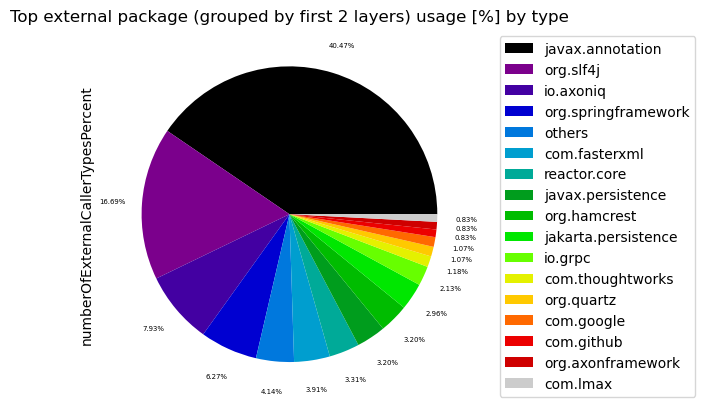

In [15]:
external_grouped_package_by_type_usage_significant = group_to_others_below_threshold(
    data_frame=external_grouped_package_usage,
    value_column='numberOfExternalCallerTypes',
    name_column='externalSecondLevelPackageName',
    threshold= 0.7
);

if external_grouped_package_by_type_usage_significant.empty:
    print("No data to plot")
else:
    plot.figure();

    axis = external_grouped_package_by_type_usage_significant.plot(
        kind='pie',
        title='Top external package (grouped by first 2 layers) usage [%] by type',
        legend=True,
        labeldistance=None,
        autopct='%1.2f%%',
        textprops={'fontsize': 5},
        pctdistance=1.2,
        cmap=main_color_map
    )
    axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot.show()

#### Table 2 Chart 2 - Most called second level external packages in % by package

External package groups that are used less than 0.7% are grouped into the name "others" to get a cleaner chart
with the most significant external packages and how ofter they are called in percent.

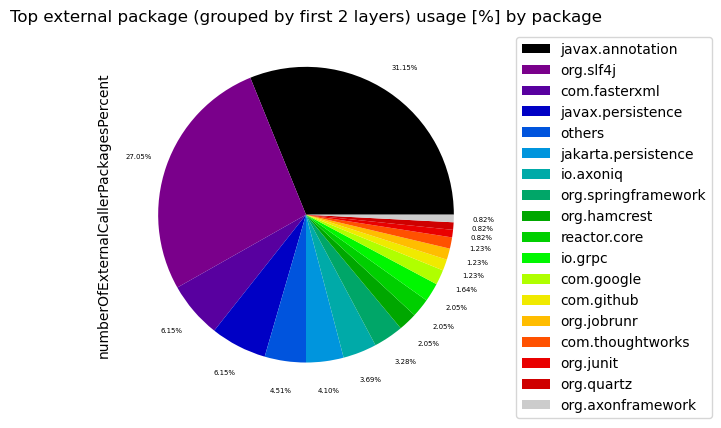

In [16]:
external_grouped_package_by_package_usage_significant = group_to_others_below_threshold(
    data_frame=external_grouped_package_usage,
    value_column='numberOfExternalCallerPackages',
    name_column='externalSecondLevelPackageName',
    threshold= 0.7
);

if external_grouped_package_by_package_usage_significant.empty:
    print("No data to plot")
else:
    plot.figure();
    axis = external_grouped_package_by_package_usage_significant.plot(
        kind='pie',
        title='Top external package (grouped by first 2 layers) usage [%] by package',
        legend=True,
        labeldistance=None,
        autopct='%1.2f%%',
        textprops={'fontsize': 5},
        pctdistance=1.2,
        cmap=main_color_map
    )
    axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot.show()

### Table 3 - Top 20 most widely spread external packages

The following tables shows external packages that are used by many different artifacts with the highest number of artifacts first. External annotations are filtered out to only get those external packages that significantly add to coupling.

Statistics like minimum, maximum, average, median and standard deviation are provided for the number of packages and number of types in every artifact that uses the listed external package. 

The intuition behind that is to find external package dependencies that are used in a widely spread manner. This should uncover libraries and frameworks and make it easier to distinguish them from external dependencies that are used for specific tasks. It can also be used to find external dependencies that are used sparsely regarding artifacts but are used in many different packages there. This could then be improved by applying a [Hexagonal architecture](https://alistair.cockburn.us/hexagonal-architecture).

Only the top 20 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_spread`

**Columns:**
- *externalPackageName* identifies the external package as defined above. All other columns contain aggregated data for this external package.
- *numberOfArtifacts* contains the number of artifacts that use the external package
- *sumNumberOfPackages* contains the sum of all packages that use the external package
- *min/max/med/avg/stdNumberOfPackages* provide statistics based on the number of packages of each artifact that uses the external package
- *min/max/med/avg/stdNumberOfPackagesPercentage* provide statistics in percent (%) based on the number of packages of each artifact that uses the external package
- *min/max/med/avg/stdNumberOfTypes* provide statistics based on the number of types of each artifact that uses the external package
- *min/max/med/avg/stdNumberOfPackagesPercentage* provide statistics in percent (%) based on the number of types of each artifact that uses the external package
- *someArtifactNames* contain some of the artifacts that contain the external package for reference

In [17]:
# Query the graph database to provide the 
# most widely spread external dependencies for the tables/charts below.
external_package_usage_spread=query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_spread.cypher")
external_package_usage_spread.head(10)

,externalPackageName,numberOfArtifacts,sumNumberOfPackages,minNumberOfPackages,maxNumberOfPackages,medNumberOfPackages,avgNumberOfPackages,stdNumberOfPackages,minNumberOfPackagesPercentage,maxNumberOfPackagesPercentage,...,maxNumberOfTypes,medNumberOfTypes,avgNumberOfTypes,stdNumberOfTypes,minNumberOfTypesPercentage,maxNumberOfTypesPercentage,medNumberOfTypesPercentage,avgNumberOfTypesPercentage,stdNumberOfTypesPercentage,someArtifactNames
0,org.slf4j,9,66,1,38,3.0,7.333333,11.821590,25.000000,100.000000,...,78,8.0,15.666667,24.067613,2.298851,36.363636,10.526316,13.268051,10.242570,"[axon-server-connector-4.10.0, axon-modelling-..."
1,jakarta.persistence,4,8,1,3,2.0,2.000000,0.816497,4.687500,22.222222,...,8,3.0,4.250000,2.500000,1.016518,4.054054,2.089358,2.312322,1.273769,"[axon-modelling-4.10.0, axon-eventsourcing-4.1..."
2,javax.persistence,4,11,2,4,2.5,2.750000,0.957427,6.250000,30.000000,...,8,3.0,4.250000,2.500000,1.016518,4.054054,2.089358,2.312322,1.273769,"[axon-modelling-4.10.0, axon-eventsourcing-4.1..."
3,com.fasterxml.jackson.databind,2,2,1,1,1.0,1.000000,0.000000,1.562500,11.111111,...,7,4.5,4.500000,3.535534,0.889454,2.702703,1.796078,1.796078,1.282161,"[axon-messaging-4.10.0, axon-spring-boot-autoc..."
4,com.github.kagkarlsson.scheduler,2,3,1,2,1.5,1.500000,0.707107,3.125000,11.111111,...,4,2.5,2.500000,2.121320,0.508259,1.351351,0.929805,0.929805,0.596156,"[axon-messaging-4.10.0, axon-spring-boot-autoc..."
5,com.github.kagkarlsson.scheduler.task,2,3,1,2,1.5,1.500000,0.707107,3.125000,11.111111,...,4,2.5,2.500000,2.121320,0.508259,1.351351,0.929805,0.929805,0.596156,"[axon-messaging-4.10.0, axon-spring-boot-autoc..."
6,com.thoughtworks.xstream,2,3,1,2,1.5,1.500000,0.707107,3.125000,11.111111,...,4,3.0,3.000000,1.414214,0.508259,2.702703,1.605481,1.605481,1.551706,"[axon-messaging-4.10.0, axon-spring-boot-autoc..."
7,io.axoniq.axonserver.connector.event,2,2,1,1,1.0,1.000000,0.000000,9.090909,11.111111,...,11,6.5,6.500000,6.363961,2.702703,8.396947,5.549825,5.549825,4.026438,"[axon-server-connector-4.10.0, axon-spring-boo..."
8,io.axoniq.axonserver.connector.impl,2,4,1,3,2.0,2.000000,1.414214,11.111111,27.272727,...,4,2.5,2.500000,2.121320,1.351351,3.053435,2.202393,2.202393,1.203555,"[axon-server-connector-4.10.0, axon-spring-boo..."
9,org.jobrunr.scheduling,2,3,1,2,1.5,1.500000,0.707107,3.125000,11.111111,...,4,2.5,2.500000,2.121320,0.508259,1.351351,0.929805,0.929805,0.596156,"[axon-messaging-4.10.0, axon-spring-boot-autoc..."


### Table 3a - Top 20 most widely spread external packages - number of internal packages

This table shows the top 20 most widely spread external packages focussing on the spread across the number of internal packages.

In [18]:
external_package_usage_spread_packages=external_package_usage_spread[['externalPackageName', 'numberOfArtifacts', 'minNumberOfPackages', 'maxNumberOfPackages', 'medNumberOfPackages', 'avgNumberOfPackages', 'stdNumberOfPackages']]
external_package_usage_spread_packages.head(20)

,externalPackageName,numberOfArtifacts,minNumberOfPackages,maxNumberOfPackages,medNumberOfPackages,avgNumberOfPackages,stdNumberOfPackages
0,org.slf4j,9,1,38,3.0,7.333333,11.821590
1,jakarta.persistence,4,1,3,2.0,2.000000,0.816497
2,javax.persistence,4,2,4,2.5,2.750000,0.957427
3,com.fasterxml.jackson.databind,2,1,1,1.0,1.000000,0.000000
4,com.github.kagkarlsson.scheduler,2,1,2,1.5,1.500000,0.707107
5,com.github.kagkarlsson.scheduler.task,2,1,2,1.5,1.500000,0.707107
6,com.thoughtworks.xstream,2,1,2,1.5,1.500000,0.707107
7,io.axoniq.axonserver.connector.event,2,1,1,1.0,1.000000,0.000000
8,io.axoniq.axonserver.connector.impl,2,1,3,2.0,2.000000,1.414214
9,org.jobrunr.scheduling,2,1,2,1.5,1.500000,0.707107


### Table 3b - Top 20 most widely spread external packages - percentage of internal packages

This table shows the top 20 most widely spread external packages focussing on the spread across the percentage of internal packages.

In [19]:
external_package_usage_spread_packages_percentage=external_package_usage_spread[['externalPackageName', 'numberOfArtifacts', 'minNumberOfPackagesPercentage', 'maxNumberOfPackagesPercentage', 'medNumberOfPackagesPercentage', 'avgNumberOfPackagesPercentage', 'stdNumberOfPackagesPercentage']]
external_package_usage_spread_packages_percentage.head(20)

,externalPackageName,numberOfArtifacts,minNumberOfPackagesPercentage,maxNumberOfPackagesPercentage,medNumberOfPackagesPercentage,avgNumberOfPackagesPercentage,stdNumberOfPackagesPercentage
0,org.slf4j,9,25.000000,100.000000,60.000000,68.342452,28.735691
1,jakarta.persistence,4,4.687500,22.222222,15.555556,14.505208,8.116903
2,javax.persistence,4,6.250000,30.000000,22.222222,20.173611,9.980289
3,com.fasterxml.jackson.databind,2,1.562500,11.111111,6.336806,6.336806,6.751888
4,com.github.kagkarlsson.scheduler,2,3.125000,11.111111,7.118056,7.118056,5.647033
5,com.github.kagkarlsson.scheduler.task,2,3.125000,11.111111,7.118056,7.118056,5.647033
6,com.thoughtworks.xstream,2,3.125000,11.111111,7.118056,7.118056,5.647033
7,io.axoniq.axonserver.connector.event,2,9.090909,11.111111,10.101010,10.101010,1.428499
8,io.axoniq.axonserver.connector.impl,2,11.111111,27.272727,19.191919,19.191919,11.427988
9,org.jobrunr.scheduling,2,3.125000,11.111111,7.118056,7.118056,5.647033


### Table 3c - Top 20 most widely spread external packages - number of internal types

This table shows the top 20 most widely spread external packages focussing on the spread across the number of internal types.

In [20]:
external_package_usage_spread_types=external_package_usage_spread[['externalPackageName', 'numberOfArtifacts', 'minNumberOfTypes', 'maxNumberOfTypes', 'medNumberOfTypes', 'avgNumberOfTypes', 'stdNumberOfTypes']]
external_package_usage_spread_types.head(20)

,externalPackageName,numberOfArtifacts,minNumberOfTypes,maxNumberOfTypes,medNumberOfTypes,avgNumberOfTypes,stdNumberOfTypes
0,org.slf4j,9,1,78,8.0,15.666667,24.067613
1,jakarta.persistence,4,3,8,3.0,4.250000,2.500000
2,javax.persistence,4,3,8,3.0,4.250000,2.500000
3,com.fasterxml.jackson.databind,2,2,7,4.5,4.500000,3.535534
4,com.github.kagkarlsson.scheduler,2,1,4,2.5,2.500000,2.121320
5,com.github.kagkarlsson.scheduler.task,2,1,4,2.5,2.500000,2.121320
6,com.thoughtworks.xstream,2,2,4,3.0,3.000000,1.414214
7,io.axoniq.axonserver.connector.event,2,2,11,6.5,6.500000,6.363961
8,io.axoniq.axonserver.connector.impl,2,1,4,2.5,2.500000,2.121320
9,org.jobrunr.scheduling,2,1,4,2.5,2.500000,2.121320


### Table 3d - Top 20 most widely spread external packages - percentage of internal types

This table shows the top 20 most widely spread external packages focussing on the spread across the percentage of internal types.

In [21]:
external_package_usage_spread_types_percentage=external_package_usage_spread[['externalPackageName', 'numberOfArtifacts', 'minNumberOfTypesPercentage', 'maxNumberOfTypesPercentage', 'medNumberOfTypesPercentage', 'avgNumberOfTypesPercentage', 'stdNumberOfTypesPercentage']]
external_package_usage_spread_types_percentage.head(20)

,externalPackageName,numberOfArtifacts,minNumberOfTypesPercentage,maxNumberOfTypesPercentage,medNumberOfTypesPercentage,avgNumberOfTypesPercentage,stdNumberOfTypesPercentage
0,org.slf4j,9,2.298851,36.363636,10.526316,13.268051,10.242570
1,jakarta.persistence,4,1.016518,4.054054,2.089358,2.312322,1.273769
2,javax.persistence,4,1.016518,4.054054,2.089358,2.312322,1.273769
3,com.fasterxml.jackson.databind,2,0.889454,2.702703,1.796078,1.796078,1.282161
4,com.github.kagkarlsson.scheduler,2,0.508259,1.351351,0.929805,0.929805,0.596156
5,com.github.kagkarlsson.scheduler.task,2,0.508259,1.351351,0.929805,0.929805,0.596156
6,com.thoughtworks.xstream,2,0.508259,2.702703,1.605481,1.605481,1.551706
7,io.axoniq.axonserver.connector.event,2,2.702703,8.396947,5.549825,5.549825,4.026438
8,io.axoniq.axonserver.connector.impl,2,1.351351,3.053435,2.202393,2.202393,1.203555
9,org.jobrunr.scheduling,2,0.508259,1.351351,0.929805,0.929805,0.596156


#### Table 3 Chart 1 - Most widely spread external packages in % by types

External packages that are used less than 0.5% are grouped into the name "others" to get a cleaner chart with the most significant external packages.

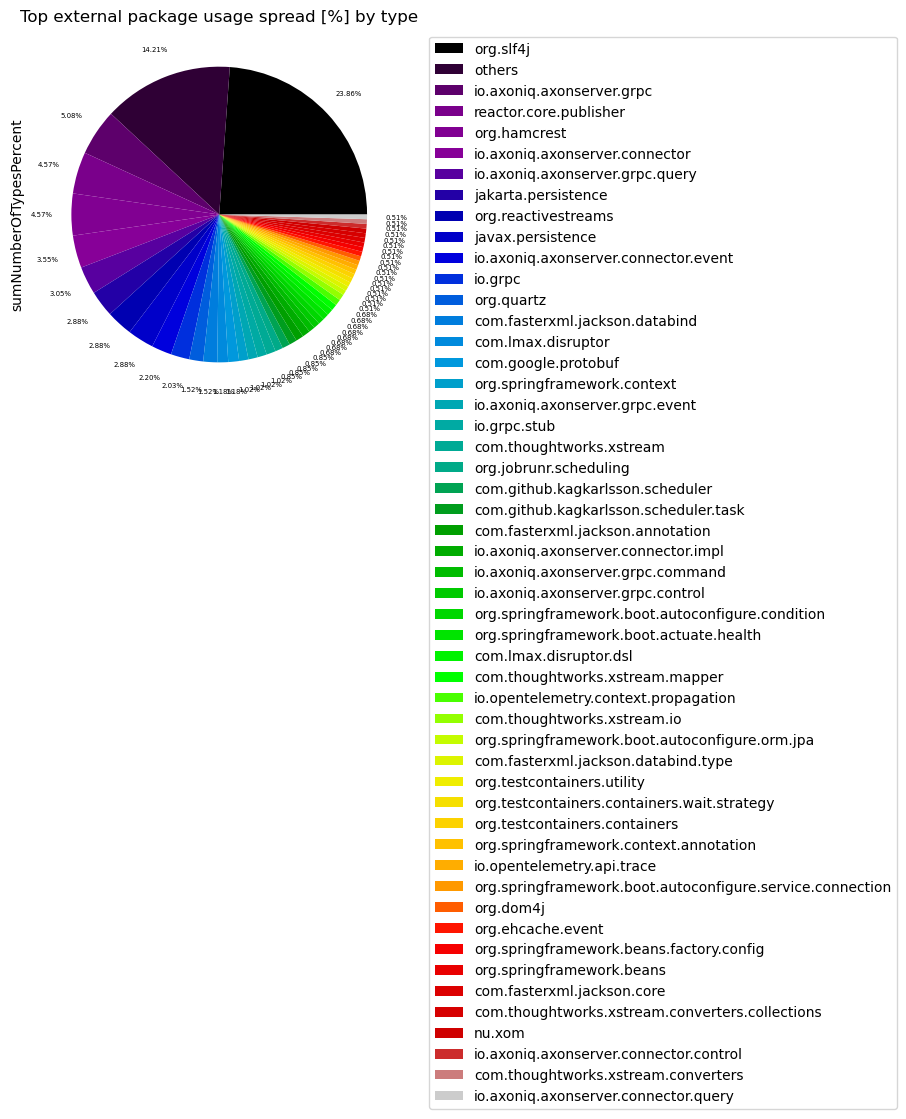

In [22]:
external_package_type_usage_spread_significant = group_to_others_below_threshold(
    data_frame=external_package_usage_spread,
    value_column='sumNumberOfTypes',
    name_column='externalPackageName',
    threshold= 0.5
);

if external_package_type_usage_spread_significant.empty:
    print("No data to plot")
else:
    plot.figure();
    axis = external_package_type_usage_spread_significant.plot(
        kind='pie',
        title='Top external package usage spread [%] by type',
        legend=True,
        labeldistance=None,
        autopct='%1.2f%%',
        textprops={'fontsize': 5},
        pctdistance=1.2,
        cmap=main_color_map
    )
    axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot.show()

#### Table 3 Chart 2 - Most widely spread external packages in % by packages

External packages that are used less than 0.5% are grouped into the name "others" to get a cleaner chart with the most significant external packages.

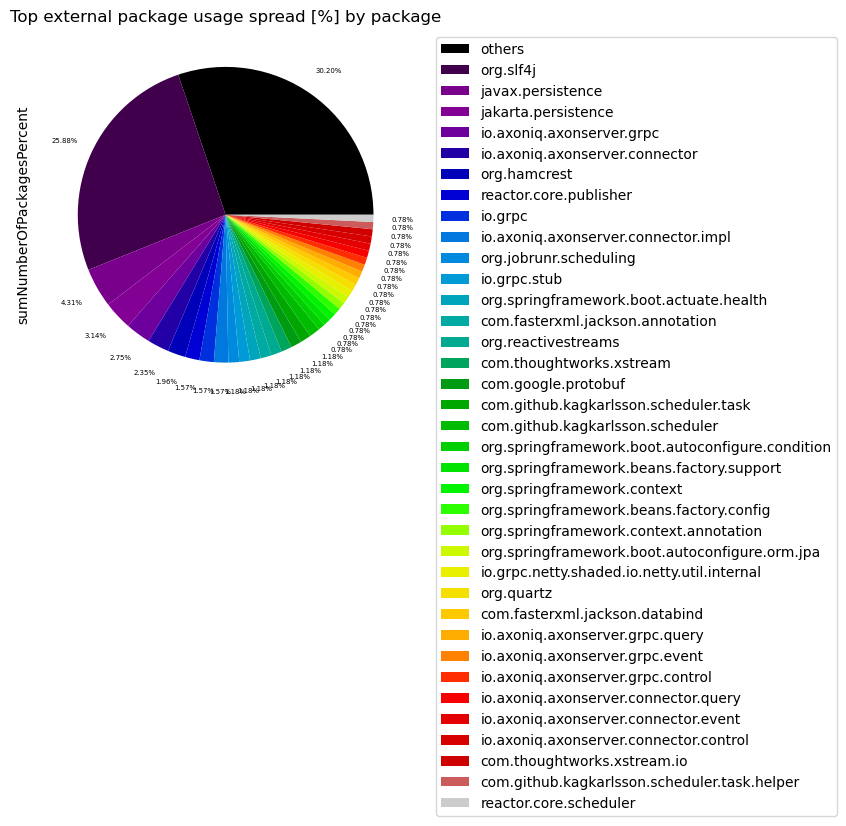

In [23]:
external_package_usage_package_spread_significant = group_to_others_below_threshold(
    data_frame=external_package_usage_spread,
    value_column='sumNumberOfPackages',
    name_column='externalPackageName',
    threshold= 0.5
);

if external_package_usage_package_spread_significant.empty:
    print("No data to plot")
else:
    plot.figure();
    axis = external_package_usage_package_spread_significant.plot(
        kind='pie',
        title='Top external package usage spread [%] by package',
        legend=True,
        labeldistance=None,
        autopct='%1.2f%%',
        textprops={'fontsize': 5},
        pctdistance=1.2,
        cmap=main_color_map
    )
    axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot.show()

### Table 4 - Top 20 most widely spread external packages grouped by their first 2 layers

This table shows external packages grouped by their first 2 layers that are used by many different artifacts with the highest number of artifacts first. External annotations are filtered out to only get those external packages that significantly add to coupling.

Statistics like minimum, maximum, average, median and standard deviation are provided for the number of packages and number of types in every artifact that uses the listed external package. 

The intuition behind that is to find external package dependencies that are used in a widely spread manner. This should uncover libraries and frameworks and make it easier to distinguish them from external dependencies that are used for specific tasks. It can also be used to find external dependencies that are used sparsely regarding artifacts but are used in many different packages there. This could then be improved by applying a [Hexagonal architecture](https://alistair.cockburn.us/hexagonal-architecture).

Only the top 20 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_spread`

**Columns:**
- *externalPackageName* identifies the external package as defined above. All other columns contain aggregated data for this external package.
- *numberOfArtifacts* contains the number of artifacts that use the external package
- *sumNumberOfPackages* contains the sum of all packages that use the external package
- *min/max/med/avg/stdNumberOfPackages* provide statistics based on the number of packages of each artifact that uses the external package
- *min/max/med/avg/stdNumberOfPackagesPercentage* provide statistics in percent (%) based on the number of packages of each artifact that uses the external package
- *min/max/med/avg/stdNumberOfTypes* provide statistics based on the number of types of each artifact that uses the external package
- *min/max/med/avg/stdNumberOfPackagesPercentage* provide statistics in percent (%) based on the number of types of each artifact that uses the external package
- *someArtifactNames* contain some of the artifacts that contain the external package for reference

In [24]:
external_grouped_package_usage_spread=query_cypher_to_data_frame("../cypher/External_Dependencies/External_second_level_package_usage_spread.cypher")
external_grouped_package_usage_spread.head(20)

,externalSecondLevelPackageName,numberOfArtifacts,sumNumberOfPackages,minNumberOfPackages,maxNumberOfPackages,medNumberOfPackages,avgNumberOfPackages,stdNumberOfPackages,minNumberOfPackagesPercentage,maxNumberOfPackagesPercentage,...,maxNumberOfTypes,medNumberOfTypes,avgNumberOfTypes,stdNumberOfTypes,minNumberOfTypesPercentage,maxNumberOfTypesPercentage,medNumberOfTypesPercentage,avgNumberOfTypesPercentage,stdNumberOfTypesPercentage,someArtifactNames
0,org.slf4j,9,66,1,38,3.0,7.333333,11.821590,25.000000,100.000000,...,78,8.0,15.666667,24.067613,2.298851,36.363636,10.526316,13.268051,10.242570,"[axon-server-connector-4.10.0, axon-modelling-..."
1,jakarta.persistence,4,8,1,3,2.0,2.000000,0.816497,4.687500,22.222222,...,8,3.0,4.250000,2.500000,1.016518,4.054054,2.089358,2.312322,1.273769,"[axon-modelling-4.10.0, axon-eventsourcing-4.1..."
2,javax.persistence,4,11,2,4,2.5,2.750000,0.957427,6.250000,30.000000,...,8,3.0,4.250000,2.500000,1.016518,4.054054,2.089358,2.312322,1.273769,"[axon-modelling-4.10.0, axon-eventsourcing-4.1..."
3,com.fasterxml,2,5,1,4,2.5,2.500000,2.121320,6.250000,11.111111,...,12,7.5,7.500000,6.363961,1.524778,4.054054,2.789416,2.789416,1.788469,"[axon-messaging-4.10.0, axon-spring-boot-autoc..."
4,com.github,2,3,1,2,1.5,1.500000,0.707107,3.125000,11.111111,...,6,3.5,3.500000,3.535534,0.762389,1.351351,1.056870,1.056870,0.416459,"[axon-messaging-4.10.0, axon-spring-boot-autoc..."
5,com.google,2,4,1,3,2.0,2.000000,1.414214,12.500000,27.272727,...,8,4.5,4.500000,4.949747,1.149425,6.106870,3.628148,3.628148,3.505443,"[axon-server-connector-4.10.0, axon-test-4.10.0]"
6,com.thoughtworks,2,3,1,2,1.5,1.500000,0.707107,3.125000,11.111111,...,8,5.0,5.000000,4.242641,1.016518,2.702703,1.859611,1.859611,1.192312,"[axon-messaging-4.10.0, axon-spring-boot-autoc..."
7,io.axoniq,2,9,1,8,4.5,4.500000,4.949747,11.111111,72.727273,...,65,33.5,33.500000,44.547727,2.702703,49.618321,26.160512,26.160512,33.174352,"[axon-server-connector-4.10.0, axon-spring-boo..."
8,org.jobrunr,2,3,1,2,1.5,1.500000,0.707107,3.125000,11.111111,...,4,2.5,2.500000,2.121320,0.508259,1.351351,0.929805,0.929805,0.596156,"[axon-messaging-4.10.0, axon-spring-boot-autoc..."
9,org.reactivestreams,2,3,1,2,1.5,1.500000,0.707107,3.125000,9.090909,...,13,8.5,8.500000,6.363961,1.651842,3.053435,2.352639,2.352639,0.991076,"[axon-server-connector-4.10.0, axon-messaging-..."


#### Table 4 Chart 1 - Most widely spread second level external packages in % by type

External package groups that are used less than 0.5% are grouped into the name "others" to get a cleaner chart
with the most significant external packages and how ofter they are called in percent.

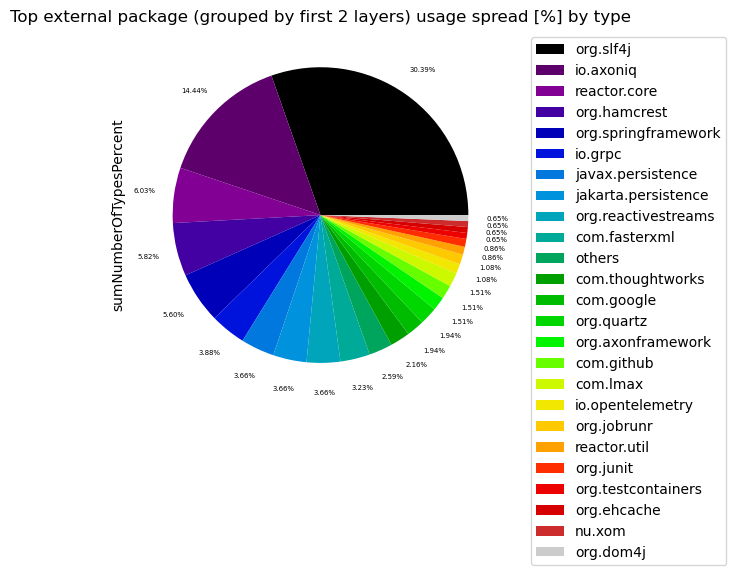

In [25]:
external_grouped_package_type_usage_spread_significant = group_to_others_below_threshold(
    data_frame=external_grouped_package_usage_spread,
    value_column='sumNumberOfTypes',
    name_column='externalSecondLevelPackageName',
    threshold= 0.5
);

if external_grouped_package_type_usage_spread_significant.empty:
    print("No data to plot")
else:
    plot.figure();

    axis = external_grouped_package_type_usage_spread_significant.plot(
        kind='pie',
        title='Top external package (grouped by first 2 layers) usage spread [%] by type',
        legend=True,
        labeldistance=None,
        autopct='%1.2f%%',
        textprops={'fontsize': 5},
        pctdistance=1.2,
        cmap=main_color_map
    )
    axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot.show()

#### Table 4 Chart 2 - Most widely spread second level external packages in % by package

External package groups that are used less than 0.5% are grouped into the name "others" to get a cleaner chart
with the most significant external packages and how ofter they are called in percent.

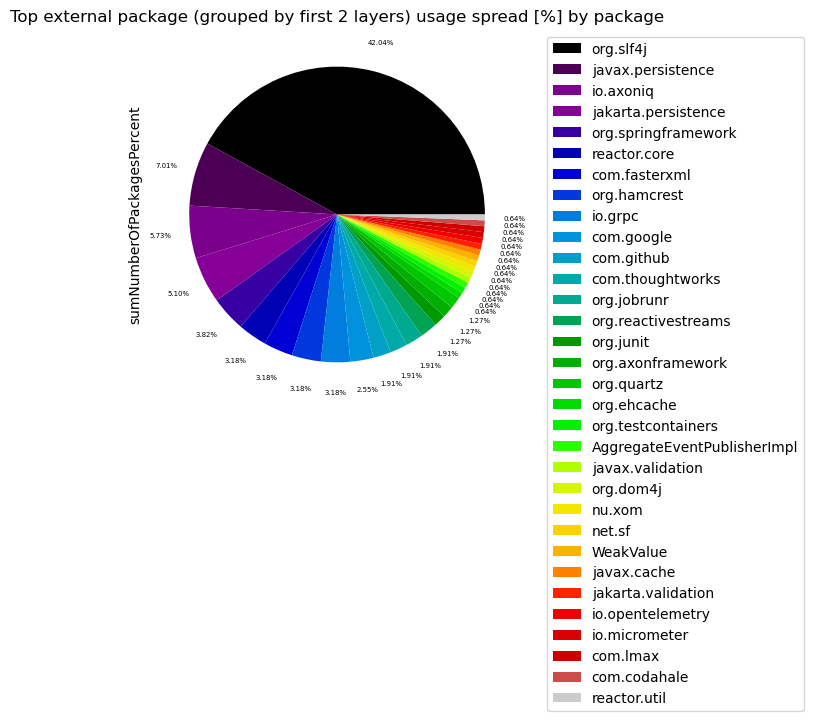

In [26]:
external_grouped_package_package_usage_spread_significant = group_to_others_below_threshold(
    data_frame=external_grouped_package_usage_spread,
    value_column='sumNumberOfPackages',
    name_column='externalSecondLevelPackageName',
    threshold= 0.5
);

if external_grouped_package_package_usage_spread_significant.empty:
    print("No data to plot")
else:
    plot.figure();

    axis = external_grouped_package_package_usage_spread_significant.plot(
        kind='pie',
        title='Top external package (grouped by first 2 layers) usage spread [%] by package',
        legend=True,
        labeldistance=None,
        autopct='%1.2f%%',
        textprops={'fontsize': 5},
        pctdistance=1.2,
        cmap=main_color_map
    )
    axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot.show()

### Table 5 - Top 20 least used external packages overall

This table identifies external packages that aren't used very often. This could help to find libraries that aren't actually needed or maybe easily replaceable. Some of them might be used sparsely on purpose for example as an adapter to an external library that is actually important. Thus, decisions need to be made on a case-by-case basis.

Only the last 20 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_overall`

**Columns:**
- *externalPackageName* identifies the external package as described above
- *numberOfExternalTypeCalls* includes every invocation or reference to the types in the external package

In [27]:
# Sort by number of external type calls
external_package_least_used=external_package_usage.sort_values(by='numberOfExternalTypeCalls', ascending=True)

# Reset index
external_package_least_used = external_package_least_used.reset_index(drop=True)

# Select columns and only show the first 10 entries (head)
external_package_least_used[['externalPackageName','numberOfExternalTypeCalls']].head(20)


,externalPackageName,numberOfExternalTypeCalls
0,org.springframework.boot.docker.compose.servic...,2
1,org.springframework.boot.docker.compose.core,2
2,org.axonframework.spring.eventsourcing,2
3,org.axonframework.spring.config.annotation,2
4,org.axonframework.micrometer,2
5,org.axonframework.metrics,2
6,reactor.core.scheduler,3
7,org.springframework.boot.context.properties.bind,3
8,com.fasterxml.jackson.databind.node,3
9,org.junit.jupiter.api.extension,3


### Table 6 - External usage per artifact sorted by highest external type rate descending

The following table shows the most used external packages separately for each artifact including external annotations. The results are sorted by the artifacts with the highest external type usage rate descending. 

The intention of this table is to find artifacts that use a lot of external dependencies in relation to their size and get all the external packages and their usage.

Only the last 40 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_per_artifact_sorted`

**Columns:**
- *artifactName* is used to group the the external package usage per artifact for a more detailed analysis.
- *externalPackageName* identifies the external package as described above
- *numberOfExternalTypeCaller* refers to the distinct types that make use of the external package
- *numberOfExternalTypeCalls* includes every invocation or reference to the types in the external package
- *numberOfTypesInArtifact* represents the total count of all analyzed types for the artifact
- *numberOfExternalTypesInArtifact* is the number of all external types that are used by the artifact
- *numberOfExternalPackagesInArtifact* is the number of all external packages that are used by the artifact
- *externalTypeRate* is the numberOfExternalTypesInArtifact / numberOfTypesInArtifact * 100
- *externalTypeNames* contains a list of actually utilized types of the external package

In [28]:
query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_per_artifact_sorted.cypher").head(40)

,artifactName,externalPackageName,numberOfExternalTypeCaller,numberOfExternalTypeCalls,numberOfTypesInArtifact,numberOfExternalTypesInArtifact,numberOfExternalPackagesInArtifact,externalTypeRate,externalTypeNames
0,axon-tracing-opentelemetry-4.10.0,io.opentelemetry.api.trace,9,47,5,16,6,320.000000,"[SpanContext, Span, StatusCode, SpanBuilder, T..."
1,axon-tracing-opentelemetry-4.10.0,io.opentelemetry.context.propagation,9,18,5,16,6,320.000000,"[TextMapSetter, TextMapGetter, TextMapPropagat..."
2,axon-tracing-opentelemetry-4.10.0,javax.annotation,3,8,5,16,6,320.000000,[Nonnull]
3,axon-tracing-opentelemetry-4.10.0,io.opentelemetry.context,2,7,5,16,6,320.000000,"[Scope, Context]"
4,axon-tracing-opentelemetry-4.10.0,org.slf4j,2,7,5,16,6,320.000000,"[LoggerFactory, Logger]"
5,axon-tracing-opentelemetry-4.10.0,io.opentelemetry.api,1,2,5,16,6,320.000000,[GlobalOpenTelemetry]
6,axon-spring-boot-autoconfigure-4.10.0,org.springframework.boot.autoconfigure.condition,66,150,74,101,47,136.486486,"[ConditionalOnProperty, ConditionalOnMissingBe..."
7,axon-spring-boot-autoconfigure-4.10.0,org.springframework.boot.autoconfigure,54,55,74,101,47,136.486486,"[AutoConfigurationPackages, AutoConfiguration,..."
8,axon-spring-boot-autoconfigure-4.10.0,org.springframework.context.annotation,41,134,74,101,47,136.486486,"[Import, Bean, ImportBeanDefinitionRegistrar, ..."
9,axon-spring-boot-autoconfigure-4.10.0,org.springframework.boot.context.properties,18,18,74,101,47,136.486486,"[ConfigurationProperties, EnableConfigurationP..."


### Table 7 - Artifacts and their external packages

The following table shows the artifacts with the highest external dependency usage broken down by each external package including external annotations. The results are sorted by the artifacts with the highest external package usage rate descending. 

The intention of this table is to find artifacts that use a lot of external dependencies and show in detail which external packages are used by them and how many internal packages.

Only the last 30 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_per_artifact_and_external_package`

**Columns:**
- *artifactName* is the name of the artifact with external dependencies (first grouping column)
- *artifactPackages* is the number of packages in the artifact
- *artifactTypes* is the number of types in the artifact
- *artifactExternalPackages* is the number of external packages used by the artifact
- *artifactExternalCallingPackages* is the number of packages that use external packages in the artifact 
- *artifactExternalCallingPackagesRate* is artifactExternalCallingPackages / artifactPackages * 100%
- *externalPackageName* the name of the external package (second grouping column)
- *numberOfPackages* is the number of internal packages of the artifact that use the external packages
- *numberOfTypes* is the number of internal types of the artifact that use the external packages
- *packagesCallingExternalRate* is numberOfPackages / artifactPackages * 100%
- *typesCallingExternalRate* is numberOfTypes / artifactTypes * 100%
- *nameOfPackages* names of the internal packages that use the external package in the artifact
- *someTypeNames* some (10) names of the internal types that use the external package in the artifact

In [29]:
external_packages_per_artifact = query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_per_artifact_and_external_package.cypher")
external_packages_per_artifact.head(30)

,artifactName,artifactPackages,artifactTypes,artifactExternalPackages,artifactExternalCallingPackages,artifactExternalCallingPackagesRate,externalPackageName,numberOfPackages,numberOfTypes,packagesCallingExternalRate,typesCallingExternalRate,nameOfPackages,someTypeNames
0,axon-configuration-4.10.0,1,41,2,1,100.0,javax.annotation,1,13,100.000000,31.707317,[org.axonframework.config],[org.axonframework.config.EventProcessingConfi...
1,axon-configuration-4.10.0,1,41,2,1,100.0,org.slf4j,1,6,100.000000,14.634146,[org.axonframework.config],"[org.axonframework.config.AxonIQConsoleModule,..."
2,axon-disruptor-4.10.0,1,22,5,1,100.0,WeakValue,1,1,100.000000,4.545455,[org.axonframework.disruptor.commandhandling],[org.axonframework.disruptor.commandhandling.F...
3,axon-disruptor-4.10.0,1,22,5,1,100.0,com.lmax.disruptor,1,7,100.000000,31.818182,[org.axonframework.disruptor.commandhandling],[org.axonframework.disruptor.commandhandling.D...
4,axon-disruptor-4.10.0,1,22,5,1,100.0,com.lmax.disruptor.dsl,1,4,100.000000,18.181818,[org.axonframework.disruptor.commandhandling],[org.axonframework.disruptor.commandhandling.D...
5,axon-disruptor-4.10.0,1,22,5,1,100.0,javax.annotation,1,6,100.000000,27.272727,[org.axonframework.disruptor.commandhandling],[org.axonframework.disruptor.commandhandling.D...
6,axon-disruptor-4.10.0,1,22,5,1,100.0,org.slf4j,1,8,100.000000,36.363636,[org.axonframework.disruptor.commandhandling],[org.axonframework.disruptor.commandhandling.D...
7,axon-spring-boot-autoconfigure-4.10.0,9,74,47,9,100.0,javax.annotation,4,8,44.444444,10.810811,"[org.axonframework.springboot.util, org.axonfr...",[org.axonframework.springboot.util.DeadLetterQ...
8,axon-spring-boot-autoconfigure-4.10.0,9,74,47,9,100.0,org.slf4j,3,4,33.333333,5.405405,"[org.axonframework.springboot.util, org.axonfr...",[org.axonframework.springboot.util.XStreamSecu...
9,axon-spring-boot-autoconfigure-4.10.0,9,74,47,9,100.0,org.springframework.boot.actuate.health,3,4,33.333333,5.405405,"[org.axonframework.actuator, org.axonframework...","[org.axonframework.actuator.HealthStatus, org...."


### Table 7a - Artifacts and their external packages (first 2 levels)

The following table groups the external packages by their first two levels. For example `javax.xml.namespace` and `javax.xml.stream` will be grouped together to `javax.xml`.

In [30]:
external_second_level_packages_per_artifact = query_cypher_to_data_frame("../cypher/External_Dependencies/External_second_level_package_usage_per_artifact_and_external_package.cypher")
external_second_level_packages_per_artifact.head(30)

,artifactName,artifactPackages,artifactTypes,artifactExternalPackagesFirst2Levels,artifactExternalCallingPackages,artifactExternalCallingPackagesRate,externalPackageNameFirst2Levels,numberOfPackages,numberOfTypes,packagesCallingExternalRate,typesCallingExternalRate,nameOfPackages,someTypeNames
0,axon-configuration-4.10.0,1,41,2,1,100.00,javax.annotation,1,13,100.000000,31.707317,[org.axonframework.config],[org.axonframework.config.EventProcessingConfi...
1,axon-configuration-4.10.0,1,41,2,1,100.00,org.slf4j,1,6,100.000000,14.634146,[org.axonframework.config],"[org.axonframework.config.AxonIQConsoleModule,..."
2,axon-disruptor-4.10.0,1,22,4,1,100.00,WeakValue,1,1,100.000000,4.545455,[org.axonframework.disruptor.commandhandling],[org.axonframework.disruptor.commandhandling.F...
3,axon-disruptor-4.10.0,1,22,4,1,100.00,com.lmax,1,7,100.000000,31.818182,[org.axonframework.disruptor.commandhandling],[org.axonframework.disruptor.commandhandling.D...
4,axon-disruptor-4.10.0,1,22,4,1,100.00,javax.annotation,1,6,100.000000,27.272727,[org.axonframework.disruptor.commandhandling],[org.axonframework.disruptor.commandhandling.D...
5,axon-disruptor-4.10.0,1,22,4,1,100.00,org.slf4j,1,8,100.000000,36.363636,[org.axonframework.disruptor.commandhandling],[org.axonframework.disruptor.commandhandling.D...
6,axon-spring-boot-autoconfigure-4.10.0,9,74,13,9,100.00,org.springframework,7,52,77.777778,70.270270,"[org.axonframework.actuator, org.axonframework...","[org.axonframework.actuator.HealthStatus, org...."
7,axon-spring-boot-autoconfigure-4.10.0,9,74,13,9,100.00,javax.annotation,4,8,44.444444,10.810811,"[org.axonframework.springboot.util, org.axonfr...",[org.axonframework.springboot.util.DeadLetterQ...
8,axon-spring-boot-autoconfigure-4.10.0,9,74,13,9,100.00,org.slf4j,3,4,33.333333,5.405405,"[org.axonframework.springboot.util, org.axonfr...",[org.axonframework.springboot.util.XStreamSecu...
9,axon-spring-boot-autoconfigure-4.10.0,9,74,13,9,100.00,jakarta.persistence,2,3,22.222222,4.054054,"[org.axonframework.springboot.util.jpa, org.ax...",[org.axonframework.springboot.util.jpa.Contain...


#### Table 7b - Top 15 external dependency using artifacts as columns with their external packages

The following table uses pivot to show the artifacts in columns, the external dependencies in rows and the number of internal packages as values.

In [31]:
# Calculate the percentage for each value based on the global sum of all values
def percentage_global(data_frame : pd.DataFrame):
    total = data_frame.sum().sum()
    return data_frame / total * 100

In [32]:
external_packages_per_artifact_pivot = external_packages_per_artifact.copy()

# Every row represents the number of external package
external_packages_per_artifact_pivot=external_packages_per_artifact_pivot.pivot(index='externalPackageName', columns='artifactName', values='numberOfPackages')

# Sort by column sum and then take only the first 10 columns
sum_of_external_packages_per_artifact = external_packages_per_artifact_pivot.sum()
external_packages_per_artifact_pivot = external_packages_per_artifact_pivot[sum_of_external_packages_per_artifact.sort_values(ascending=False).index[:15]]

# Fill missing values with zeroes
external_packages_per_artifact_pivot.fillna(0, inplace=True)

external_packages_per_artifact_pivot.astype('int')

artifactName,axon-messaging-4.10.0,axon-spring-boot-autoconfigure-4.10.0,axon-server-connector-4.10.0,axon-test-4.10.0,axon-modelling-4.10.0,axon-eventsourcing-4.10.0,axon-tracing-opentelemetry-4.10.0,axon-disruptor-4.10.0,axon-configuration-4.10.0
externalPackageName,,,,,,,,,
AggregateEventPublisherImpl,0,0,0,1,0,0,0,0,0
WeakValue,0,0,0,0,0,0,0,1,0
com.codahale.metrics,0,1,0,0,0,0,0,0,0
com.fasterxml.jackson.annotation,11,0,0,0,2,0,0,0,0
com.fasterxml.jackson.core,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
reactor.core,1,0,0,0,0,0,0,0,0
reactor.core.publisher,2,0,2,0,0,0,0,0,0
reactor.core.scheduler,0,0,2,0,0,0,0,0,0


#### Table 7c - Top 15 external dependency using artifacts as columns with their external packages (first 2 levels)

The following table uses pivot to show the artifacts in columns, the external package name grouped by its first two levels in rows and the number of internal packages as values. For example `javax.xml.namespace` and `javax.xml.stream` will be grouped together to `javax.xml`.

In [33]:
external_second_level_packages_per_artifact_pivot = external_second_level_packages_per_artifact.copy()

# Every row represents the number of external package
external_second_level_packages_per_artifact_pivot=external_second_level_packages_per_artifact_pivot.pivot(index='externalPackageNameFirst2Levels', columns='artifactName', values='numberOfPackages')

# Sort by column sum and then take only the first 10 columns
sum_of_external_second_level_packages_per_artifact = external_second_level_packages_per_artifact_pivot.sum()
external_second_level_packages_per_artifact_pivot = external_second_level_packages_per_artifact_pivot[sum_of_external_second_level_packages_per_artifact.sort_values(ascending=False).index[:15]]

# Fill missing values with zeroes
external_second_level_packages_per_artifact_pivot.fillna(0, inplace=True)

external_second_level_packages_per_artifact_pivot.astype('int')

artifactName,axon-messaging-4.10.0,axon-server-connector-4.10.0,axon-spring-boot-autoconfigure-4.10.0,axon-modelling-4.10.0,axon-eventsourcing-4.10.0,axon-test-4.10.0,axon-disruptor-4.10.0,axon-tracing-opentelemetry-4.10.0,axon-configuration-4.10.0
externalPackageNameFirst2Levels,,,,,,,,,
AggregateEventPublisherImpl,0,0,0,0,0,1,0,0,0
WeakValue,0,0,0,0,0,0,1,0,0
com.codahale,0,0,1,0,0,0,0,0,0
com.fasterxml,12,0,1,2,0,0,0,0,0
com.github,2,0,1,0,0,0,0,0,0
com.google,0,3,0,0,0,1,0,0,0
com.lmax,0,0,0,0,0,0,1,0,0
com.thoughtworks,2,0,1,0,0,0,0,0,0
io.axoniq,0,8,1,0,0,0,0,0,0


#### Table 7 Chart 1 - Top 15 external dependency using artifacts and their external packages stacked

The following chart shows the top 15 external package using artifacts and breaks down which external packages they use in how many different internal packages with stacked bars. 

Note that every external dependency is counted separately so that if on internal package uses two external packages it will be displayed for both and so stacked twice.  

<Figure size 640x480 with 0 Axes>

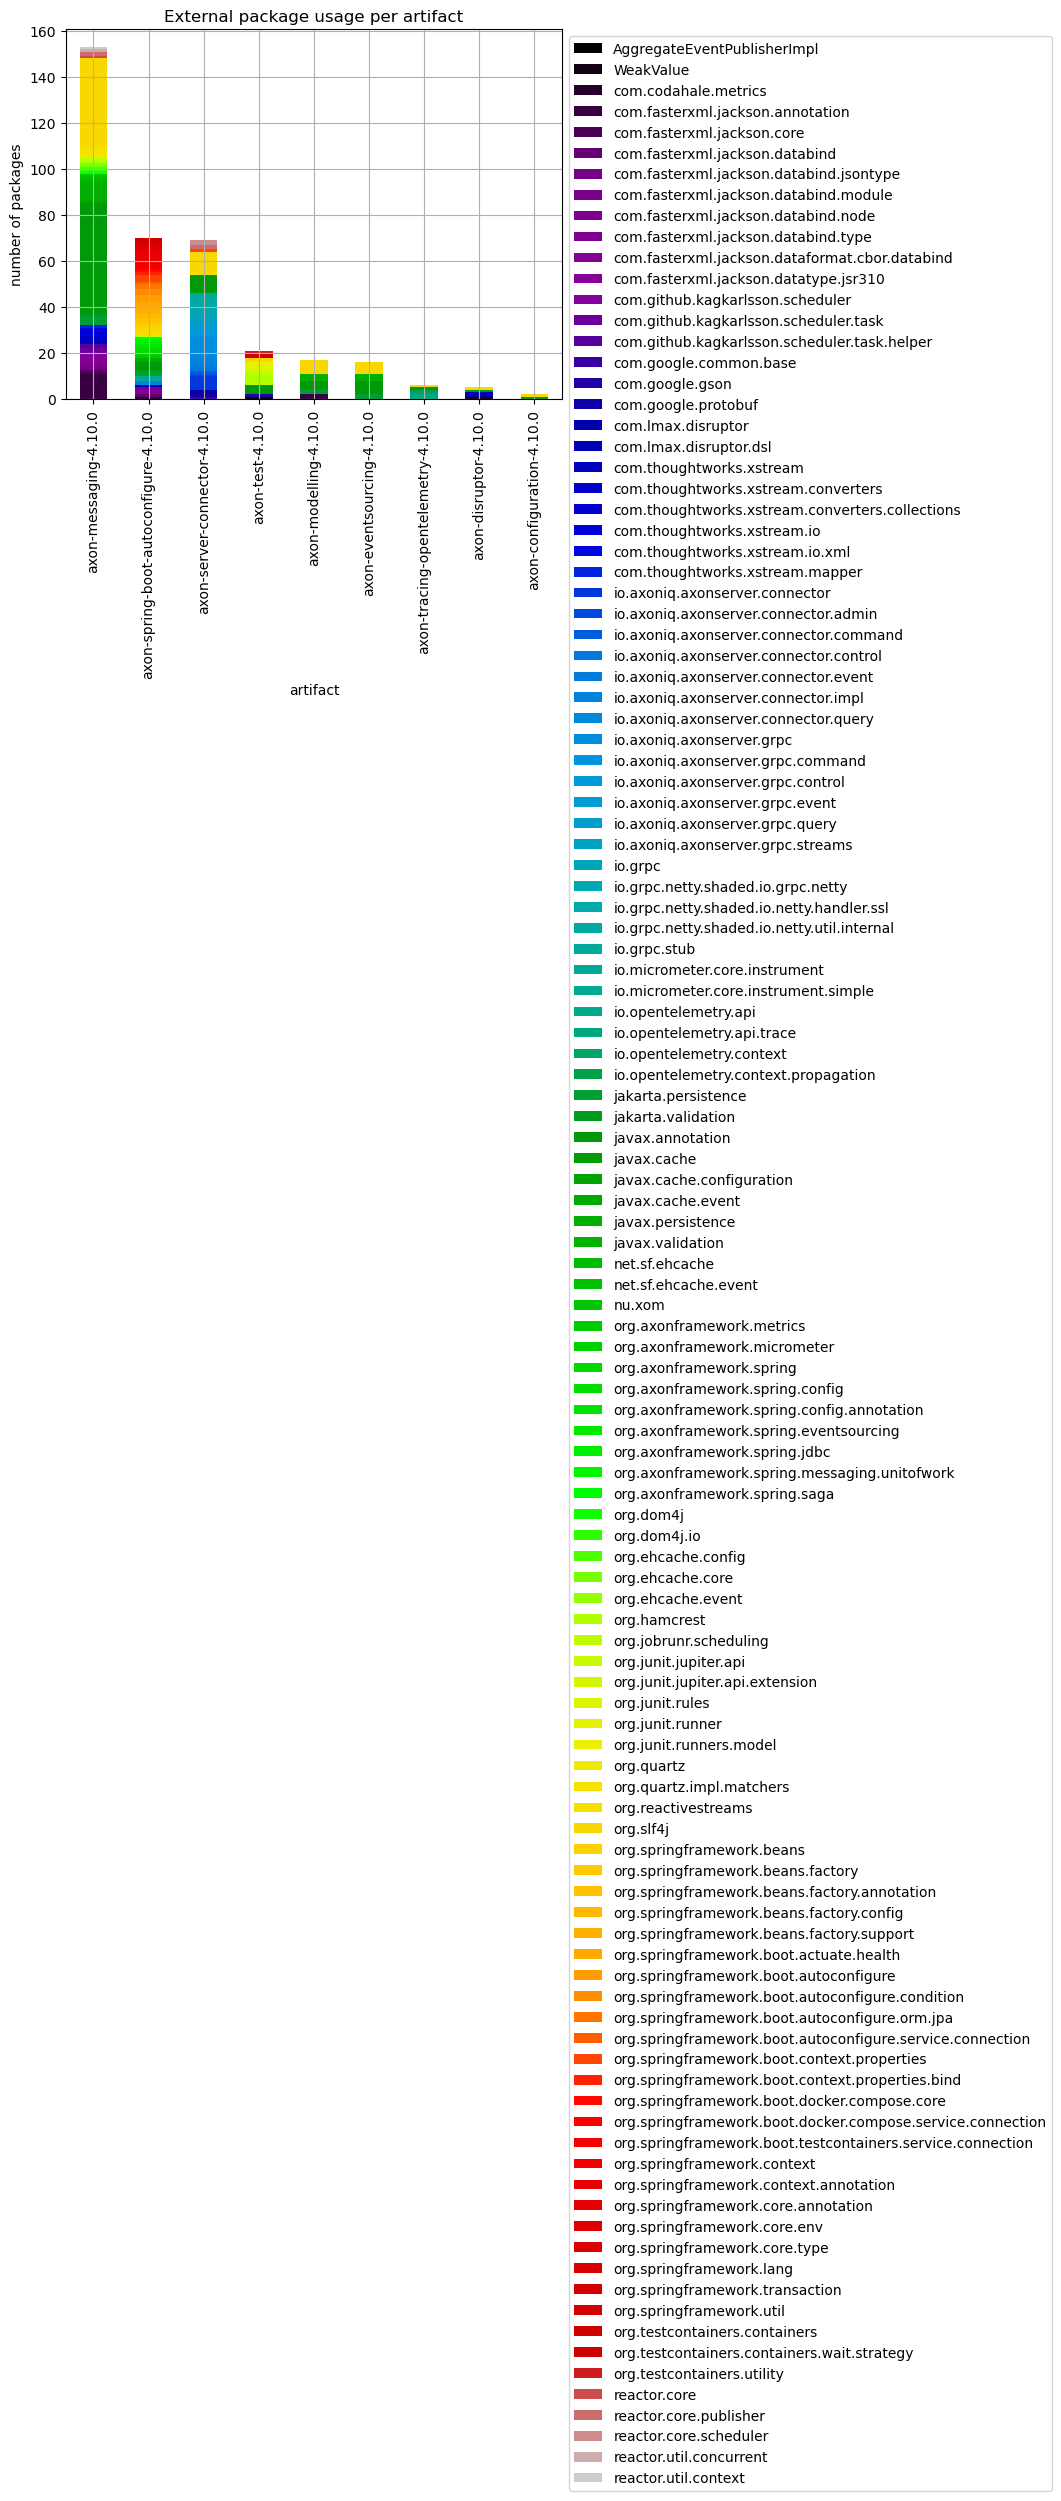

In [34]:
if external_packages_per_artifact_pivot.empty:
    print("No data to plot")
else:
    plot.figure();
    axes = external_packages_per_artifact_pivot.transpose().plot(
        kind='bar', 
        grid=True,
        title='External package usage per artifact', 
        xlabel='artifact',
        ylabel='number of packages',
        stacked=True,
        legend=True,
        cmap=main_color_map
    ).legend(bbox_to_anchor=(1.0, 1.0))
    plot.show()

#### Table 7 Chart 2 - Top 15 external dependency using artifacts and their external packages (first 2 levels) stacked

The following chart shows the top 15 external package using artifacts and breaks down which external packages (first 2 levels) are used in how many different internal packages with stacked bars. 

Note that every external dependency is counted separately so that if on internal package uses two external packages it will be displayed for both and so stacked twice.  

<Figure size 640x480 with 0 Axes>

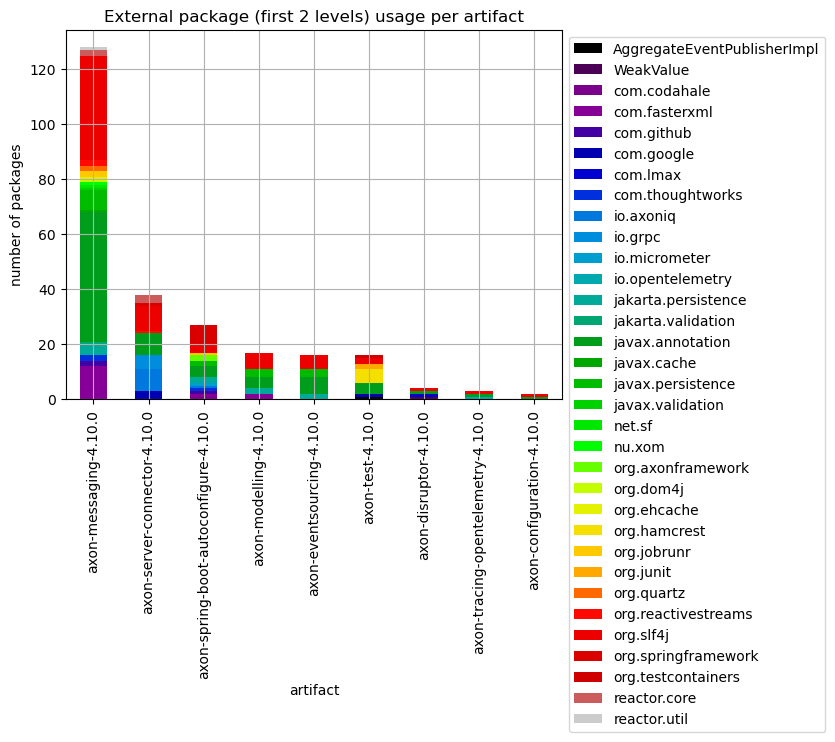

In [35]:
if external_second_level_packages_per_artifact_pivot.empty:
    print("No data to plot")
else:
    plot.figure();
    axes = external_second_level_packages_per_artifact_pivot.transpose().plot(
        kind='bar', 
        grid=True,
        title='External package (first 2 levels) usage per artifact', 
        xlabel='artifact',
        ylabel='number of packages',
        stacked=True,
        legend=True,
        cmap=main_color_map
    ).legend(bbox_to_anchor=(1.0, 1.0))
    plot.show()

### Table 8 - External usage per artifact

The following table shows the most used external packages separately for each artifact including external annotations. The results are grouped per artifact and sorted by the artifacts with the highest external type usage rate descending. Additionally, for each artifact the top 5 used external packages are listed in the top5ExternalPackages column. 

The intention of this table is to find artifacts that use a lot of external dependencies in relation to their size and get an overview per artifact with the top 5 used external packages, the number of external types and packages used etc. .

Only the last 40 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_per_artifact_sorted_top`

**Columns:**
- *artifactName* is used to group the the external package usage per artifact for a more detailed analysis.
- *numberOfTypesInArtifact* represents the total count of all analyzed types for the artifact
- *numberOfExternalTypesInArtifact* is the number of all external types that are used by the artifact
- *numberOfExternalPackagesInArtifact* is the number of all external packages that are used by the artifact
- *externalTypeRate* is the numberOfExternalTypesInArtifact / numberOfTypesInArtifact * 100
- *numberOfExternalTypeCaller* refers to the distinct types that make use of the external package
- *numberOfExternalTypeCalls* includes every invocation or reference to the types in the external package
- *numberOfExternalPackages* is the number of distinct external packages used by the artifact
- *top5ExternalPackages* contains a list of the top 5 most used external packages of the artifact
- *someExternalTypes* contains a list of lists and is also mean't to provide some examples of external types used

In [36]:
query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_per_artifact_sorted_top.cypher").head(40)

,artifactName,numberOfTypesInArtifact,numberOfExternalTypesInArtifact,numberOfExternalPackagesInArtifact,externalTypeRate,numberOfExternalTypeCaller,numberOfExternalTypeCalls,numberOfExternalPackages,top5ExternalPackages,someExternalTypes
0,axon-tracing-opentelemetry-4.10.0,5,16,6,320.000000,26,89,6,"[io.opentelemetry.context.propagation, io.open...","[TextMapSetter, TextMapGetter, TextMapPropagat..."
1,axon-spring-boot-autoconfigure-4.10.0,74,101,47,136.486486,304,672,47,[org.springframework.boot.autoconfigure.condit...,"[ConditionalOnProperty, ConditionalOnMissingBe..."
2,axon-server-connector-4.10.0,131,113,26,86.259542,341,1383,26,"[io.axoniq.axonserver.grpc, io.grpc, io.axoniq...","[FlowControl, FlowControl$Builder, SerializedO..."
3,axon-disruptor-4.10.0,22,13,5,59.090909,33,93,5,"[org.slf4j, com.lmax.disruptor, javax.annotati...","[Logger, LoggerFactory, RingBuffer, BlockingWa..."
4,axon-test-4.10.0,87,28,13,32.183908,99,500,13,"[org.hamcrest, javax.annotation, org.testconta...","[Matcher, TypeSafeMatcher, Description, String..."
5,axon-modelling-4.10.0,156,35,5,22.435897,99,356,5,"[javax.annotation, javax.persistence, jakarta....","[Nonnull, Nullable, LockModeType, EntityManage..."
6,axon-messaging-4.10.0,787,154,42,19.567980,747,2971,42,"[javax.annotation, org.slf4j, com.fasterxml.ja...","[Nonnull, Nullable, LoggerFactory, Logger, Jso..."
7,axon-eventsourcing-4.10.0,133,25,4,18.796992,74,238,4,"[javax.annotation, org.slf4j, javax.persistenc...","[Nonnull, PreDestroy, Nullable, Logger, Logger..."
8,axon-configuration-4.10.0,41,4,2,9.756098,24,137,2,"[javax.annotation, org.slf4j]","[Nonnull, Nullable, Logger, LoggerFactory]"


### Table 9 - External usage per artifact and package

This table lists internal packages and the artifacts they belong to that use many different external types of a specific external package without taking external annotations into account. 

Only the last 40 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_per_artifact_and_package`

**Columns:**
- *artifactName* that contains the type that calls the external package
- *fullPackageName* is the package within the artifact that contains the type that calls the external package
- *externalPackageName* identifies the external package as described above
- *numberOfExternalTypeCaller* refers to the distinct types that make use of the external package
- *numberOfExternalTypeCalls* includes every invocation or reference to the types in the external package
- *numberOfTypesInPackage* represents the total count of all types in that package
- *externalTypeNames* contains a list of actually utilized types of the external package
- *packageName* contains the name of the package (last part of *fullPackageName*)

In [37]:
external_package_usage_per_package = query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_per_artifact_and_package.cypher")
external_package_usage_per_package.head(40)

,artifactName,fullPackageName,externalPackageName,numberOfExternalTypeCaller,numberOfExternalTypeCalls,numberOfTypesInPackage,externalTypeNames,packageName
0,axon-server-connector-4.10.0,org.axonframework.axonserver.connector.util,io.grpc,39,69,26,"[ClientInterceptor, MethodDescriptor, Channel,...",util
1,axon-test-4.10.0,org.axonframework.test.matchers,org.hamcrest,38,147,24,"[Description, Matcher, BaseMatcher, TypeSafeMa...",matchers
2,axon-messaging-4.10.0,org.axonframework.queryhandling,reactor.core.publisher,28,108,48,"[MonoSink, Flux, Mono, FluxSink, Sinks$Many, S...",queryhandling
3,axon-server-connector-4.10.0,org.axonframework.axonserver.connector.query,io.axoniq.axonserver.grpc.query,25,124,21,"[SubscriptionQuery, QueryResponse, QueryUpdate...",query
4,axon-server-connector-4.10.0,org.axonframework.axonserver.connector.query.s...,io.axoniq.axonserver.grpc.query,21,113,6,"[QueryUpdate, QueryResponse, QueryProviderOutb...",subscription
5,axon-server-connector-4.10.0,org.axonframework.axonserver.connector.util,io.axoniq.axonserver.grpc,20,106,26,"[MetaDataValue$DataCase, SerializedObject$Buil...",util
6,axon-messaging-4.10.0,org.axonframework.deadline.quartz,org.quartz,18,109,4,"[Scheduler, JobExecutionContext, JobExecutionE...",quartz
7,axon-server-connector-4.10.0,org.axonframework.axonserver.connector.event.axon,io.axoniq.axonserver.connector.event,18,89,26,"[PersistentStreamProperties, EventStream, Even...",axon
8,axon-messaging-4.10.0,org.axonframework.eventhandling.scheduling.quartz,org.quartz,17,76,6,"[JobBuilder, JobDetail, Trigger, JobKey, Sched...",quartz
9,axon-server-connector-4.10.0,org.axonframework.axonserver.connector.query,io.axoniq.axonserver.connector,17,53,21,"[Registration, FlowControl, ReplyChannel, Resu...",query


### Table 10 - Top 20 external package usage per type

This table shows internal types that utilize the most different external types and packages. These have the highest probability of change depending on external libraries. A case-by-case approach is also advisable here because there could for example also be code units that encapsulate an external library and have this high count of external dependencies on purpose.

Only the last 20 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_per_type`

**Columns:**
- *artifactName* that contains the type that calls the external package
- *fullPackageName* is the package within the artifact that contains the type that calls external types
- *typeName* identifies the internal type within the package and artifact that calls external types
- *numberOfExternalTypeCaller* and *numberOfExternalTypes* refers to the distinct external types that are used by the internal type
- *numberOfExternalTypeCalls* includes every invocation or reference to the types in the external package
- *numberOfTypesInPackage* represents the total count of all types in that package
- *numberOfExternalPackages* shows how many different external packages are used by the internal type
- *externalPackageNames* contains the list of names of the different external packages that are used by the internal type
- *externalTypeNames* contains a list of actually utilized types of the external package
- *packageName* contains the name of the package (last part of *fullPackageName*)

In [38]:
external_package_usage_per_type = query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_per_type.cypher")
external_package_usage_per_type.head(20)

,artifactName,fullPackageName,typeName,numberOfExternalTypeCaller,numberOfExternalTypeCalls,numberOfExternalPackages,numberOfExternalTypes,externalPackageNames,externalTypeNames,packageName,fullTypeName
0,axon-spring-boot-autoconfigure-4.10.0,org.axonframework.springboot.autoconfig,AxonAutoConfiguration,19,91,12,19,"[org.springframework.boot.autoconfigure, org.s...",[org.springframework.boot.autoconfigure.AutoCo...,autoconfig,org.axonframework.springboot.autoconfig.AxonAu...
1,axon-spring-boot-autoconfigure-4.10.0,org.axonframework.springboot.autoconfig,InfraConfiguration,18,53,9,18,"[org.springframework.boot.autoconfigure, org.s...",[org.springframework.boot.autoconfigure.AutoCo...,autoconfig,org.axonframework.springboot.autoconfig.InfraC...
2,axon-server-connector-4.10.0,org.axonframework.axonserver.connector.query,AxonServerQueryBus,15,72,8,15,"[javax.annotation, reactor.core.scheduler, org...","[javax.annotation.Nonnull, reactor.core.schedu...",query,org.axonframework.axonserver.connector.query.A...
3,axon-spring-boot-autoconfigure-4.10.0,org.axonframework.springboot.autoconfig,AxonServerAutoConfiguration,12,38,8,12,[org.springframework.boot.autoconfigure.condit...,[org.springframework.boot.autoconfigure.condit...,autoconfig,org.axonframework.springboot.autoconfig.AxonSe...
4,axon-spring-boot-autoconfigure-4.10.0,org.axonframework.springboot.util,AbstractQualifiedBeanCondition,12,24,8,12,[org.springframework.boot.autoconfigure.condit...,[org.springframework.boot.autoconfigure.condit...,util,org.axonframework.springboot.util.AbstractQual...
5,axon-server-connector-4.10.0,org.axonframework.axonserver.connector.event.axon,AxonServerEventStore$AxonIQEventStorageEngine,12,58,7,12,"[javax.annotation, io.axoniq.axonserver.grpc, ...","[javax.annotation.Nonnull, io.axoniq.axonserve...",axon,org.axonframework.axonserver.connector.event.a...
6,axon-spring-boot-autoconfigure-4.10.0,org.axonframework.springboot.autoconfig,MicrometerMetricsAutoConfiguration,13,30,7,13,[org.springframework.boot.autoconfigure.condit...,[org.springframework.boot.autoconfigure.condit...,autoconfig,org.axonframework.springboot.autoconfig.Microm...
7,axon-spring-boot-autoconfigure-4.10.0,org.axonframework.springboot.autoconfig,AxonDbSchedulerAutoConfiguration,9,26,7,9,"[org.springframework.boot.autoconfigure, org.s...",[org.springframework.boot.autoconfigure.AutoCo...,autoconfig,org.axonframework.springboot.autoconfig.AxonDb...
8,axon-spring-boot-autoconfigure-4.10.0,org.axonframework.springboot.autoconfig,JpaAutoConfiguration,10,19,7,10,"[org.springframework.boot.autoconfigure, org.s...",[org.springframework.boot.autoconfigure.AutoCo...,autoconfig,org.axonframework.springboot.autoconfig.JpaAut...
9,axon-spring-boot-autoconfigure-4.10.0,org.axonframework.springboot.autoconfig,XStreamAutoConfiguration,11,15,7,11,"[org.springframework.boot.autoconfigure, org.s...",[org.springframework.boot.autoconfigure.AutoCo...,autoconfig,org.axonframework.springboot.autoconfig.XStrea...


### Table 11 - External package usage distribution per type

This table shows how many types use one external package, how many use two, etc. .
This gives an overview of the distribution of external package calls and the overall coupling to external libraries. The higher the count of distinct external packages the lower should be the count of types that use them. Dependencies to external annotations are left out here.

More details about which types have the highest external package dependency usage can be in the tables 4 and 5 above.

Only the last 40 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_per_artifact_distribution`

**Columns:**
- *artifactName* that contains the type that calls the external package
- *artifactTypes* the total count of types in the artifact
- *numberOfExternalPackages* the number of distinct external packages used
- *numberOfTypes* in the artifact where the *numberOfExternalPackages* applies
- *numberOfTypesPercentage* in the artifact where the *numberOfExternalPackages* applies in %

In [39]:
external_package_usage_per_artifact_distribution = query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_per_artifact_distribution.cypher")
external_package_usage_per_artifact_distribution_truncated=external_package_usage_per_artifact_distribution[['artifactName', 'artifactPackages', 'artifactTypes', 'numberOfExternalPackages', 'numberOfPackages', 'numberOfTypes', 'typesCallingExternalRate', 'packagesCallingExternalRate']].head(40)
external_package_usage_per_artifact_distribution_truncated

,artifactName,artifactPackages,artifactTypes,numberOfExternalPackages,numberOfPackages,numberOfTypes,typesCallingExternalRate,packagesCallingExternalRate
0,axon-messaging-4.10.0,64,787,41,44,155,19.695044,68.750000
1,axon-server-connector-4.10.0,11,131,24,10,82,62.595420,90.909091
2,axon-spring-boot-autoconfigure-4.10.0,9,74,43,8,35,47.297297,88.888889
3,axon-modelling-4.10.0,10,156,3,7,12,7.692308,70.000000
4,axon-test-4.10.0,8,87,12,6,36,41.379310,75.000000
5,axon-eventsourcing-4.10.0,9,133,3,5,15,11.278195,55.555556
6,axon-configuration-4.10.0,1,41,1,1,6,14.634146,100.000000
7,axon-disruptor-4.10.0,1,22,4,1,10,45.454545,100.000000
8,axon-tracing-opentelemetry-4.10.0,1,5,5,1,5,100.000000,100.000000


### Table 12 - External package usage per artifact grouped by number of internal packages

The following table shows the external package usage for every artifact grouped by the number of distinct internal dependent packages. The intention is to find external package usage spread across multiple internal packages in artifacts. 

Artifacts that encapsulate external dependency calls in one internal package overall (or each) are easier to change if those external dependencies change and are most likely applying a [Hexagonal architecture](https://alistair.cockburn.us/hexagonal-architecture). Artifacts that use external dependencies in multiple internal packages need more effort to adapt to changes of those external dependencies. On one hand this could be intended e.g. when using standardized libraries. On the other hand this might indicate higher than necessary coupling.

The whole table can be found in the following CSV report:
`External_package_usage_per_internal_package_count`

In [40]:
external_package_usage_per_package_distribution = query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_per_internal_package_count.cypher")

# Only show external dependencies that are at least used in 2 internal packages. 
# Filter out all rows with "numberOfPackages" <= 2.
external_package_usage_per_package_distribution=external_package_usage_per_package_distribution.query("`numberOfPackages` >= 2")
# Organize artifacts in columns with the number of packages that call external packages as values using pivot
# Every row represents the number of external packages
external_package_usage_per_package_distribution=external_package_usage_per_package_distribution.pivot(index='numberOfPackages', columns='artifactName', values='maxPackagesCallingExternalRate')

# Fill missing values with zero
external_package_usage_per_package_distribution.fillna(0, inplace=True)

external_package_usage_per_package_distribution

artifactName,axon-eventsourcing-4.10.0,axon-messaging-4.10.0,axon-modelling-4.10.0,axon-server-connector-4.10.0,axon-spring-boot-autoconfigure-4.10.0,axon-test-4.10.0
numberOfPackages,,,,,,
2,22.222222,3.1250,20.0,18.181818,22.222222,25.0
3,33.333333,0.0000,30.0,27.272727,33.333333,0.0
4,0.000000,6.2500,40.0,36.363636,44.444444,50.0
5,55.555556,0.0000,0.0,0.000000,0.000000,62.5
6,66.666667,0.0000,60.0,54.545455,0.000000,0.0
7,0.000000,10.9375,0.0,63.636364,0.000000,0.0
8,0.000000,0.0000,0.0,72.727273,0.000000,0.0
9,0.000000,0.0000,0.0,81.818182,0.000000,0.0
11,0.000000,17.1875,0.0,0.000000,0.000000,0.0


### Table 13 - External package usage aggregated

This table lists all artifacts and their external package dependencies usage aggregated over internal packages. 

The intention behind this is to find artifacts that use an external dependency across multiple internal packages. This might be intended for frameworks and standardized libraries and helps to quantify how widely those are used. For some external dependencies it might be beneficial to only access it from one package and provide an abstraction for internal usage following a [Hexagonal architecture](https://alistair.cockburn.us/hexagonal-architecture). Thus, this table may also help in finding application for the Hexagonal architecture or similar approaches (Domain Driven Design Anti Corruption Layer). After all it is easier to update or replace such external dependencies when they are used in specific areas and not all over the code.

Only the last 40 entries are shown. The whole table can be found in the following CSV report:
`External_package_usage_per_artifact_package_aggregated`

**Columns:**
- *artifactName* that contains the type that calls the external package
- *artifactPackages* is the total count of packages in the artifact
- *artifactTypes* is the total count of types in the artifact
- *numberOfExternalPackages* the number of distinct external packages used
- *[min,max,med,avg,std]NumberOfPackages* provide statistics based on each external package and its package usage within the artifact
- *[min,max,med,avg,std]NumberOfPackagesPercentage* provide statistics in % based on each external package and its package usage within the artifact in respect to the overall count of packages in the artifact
- *[min,max,med,avg,std]NumberOfTypes* provide statistics based on each external package and its type usage within the artifact
- *[min,max,med,avg,std]NumberOfTypePercentage* provide statistics in % based on each external package and its type usage within the artifact in respect to the overall count of packages in the artifact
- *numberOfTypes* in the artifact where the *numberOfExternalPackages* applies
- *numberOfTypesPercentage* in the artifact where the *numberOfExternalPackages* applies in %

#### Table 13a - External package usage aggregated - count of internal packages

In [41]:
external_package_usage_aggregated = query_cypher_to_data_frame("../cypher/External_Dependencies/External_package_usage_per_artifact_package_aggregated.cypher")

external_package_usage_aggregated_packages = external_package_usage_aggregated[['artifactName', 'artifactPackages', 'numberOfExternalPackages', 'minNumberOfPackages', 'medNumberOfPackages', 'avgNumberOfPackages', 'maxNumberOfPackages', 'stdNumberOfPackages']]
external_package_usage_aggregated_packages.head(30)

,artifactName,artifactPackages,numberOfExternalPackages,minNumberOfPackages,medNumberOfPackages,avgNumberOfPackages,maxNumberOfPackages,stdNumberOfPackages
0,axon-messaging-4.10.0,64,41,1,1.0,2.292683,38,5.758663
1,axon-server-connector-4.10.0,11,24,1,2.0,2.500000,9,2.085144
2,axon-modelling-4.10.0,10,3,2,3.0,3.666667,6,2.081666
3,axon-eventsourcing-4.10.0,9,3,1,2.0,2.666667,5,2.081666
4,axon-test-4.10.0,8,12,1,1.0,1.416667,5,1.164500
5,axon-spring-boot-autoconfigure-4.10.0,9,43,1,1.0,1.279070,3,0.548833
6,axon-configuration-4.10.0,1,1,1,1.0,1.000000,1,0.000000
7,axon-disruptor-4.10.0,1,4,1,1.0,1.000000,1,0.000000
8,axon-tracing-opentelemetry-4.10.0,1,5,1,1.0,1.000000,1,0.000000


#### Table 13b - External package usage aggregated - percentage of internal packages

In [42]:
external_package_usage_aggregated_packages_percentage = external_package_usage_aggregated[['artifactName', 'artifactPackages', 'numberOfExternalPackages', 'minNumberOfPackagesPercentage', 'medNumberOfPackagesPercentage', 'avgNumberOfPackagesPercentage', 'maxNumberOfPackagesPercentage', 'stdNumberOfPackagesPercentage']]
external_package_usage_aggregated_packages_percentage.head(30)

,artifactName,artifactPackages,numberOfExternalPackages,minNumberOfPackagesPercentage,medNumberOfPackagesPercentage,avgNumberOfPackagesPercentage,maxNumberOfPackagesPercentage,stdNumberOfPackagesPercentage
0,axon-messaging-4.10.0,64,41,1.562500,1.562500,3.582317,59.375000,8.997910
1,axon-server-connector-4.10.0,11,24,9.090909,18.181818,22.727273,81.818182,18.955856
2,axon-modelling-4.10.0,10,3,20.000000,30.000000,36.666667,60.000000,20.816660
3,axon-eventsourcing-4.10.0,9,3,11.111111,22.222222,29.629630,55.555556,23.129622
4,axon-test-4.10.0,8,12,12.500000,12.500000,17.708333,62.500000,14.556252
5,axon-spring-boot-autoconfigure-4.10.0,9,43,11.111111,11.111111,14.211886,33.333333,6.098150
6,axon-configuration-4.10.0,1,1,100.000000,100.000000,100.000000,100.000000,0.000000
7,axon-disruptor-4.10.0,1,4,100.000000,100.000000,100.000000,100.000000,0.000000
8,axon-tracing-opentelemetry-4.10.0,1,5,100.000000,100.000000,100.000000,100.000000,0.000000


#### Table 13c - External package usage aggregated - count of internal types

In [43]:
external_package_usage_aggregated_types = external_package_usage_aggregated[['artifactName', 'artifactTypes', 'numberOfExternalPackages', 'minNumberOfTypes', 'medNumberOfTypes', 'avgNumberOfTypes', 'maxNumberOfTypes', 'stdNumberOfTypes']]
external_package_usage_aggregated_types.head(30)

,artifactName,artifactTypes,numberOfExternalPackages,minNumberOfTypes,medNumberOfTypes,avgNumberOfTypes,maxNumberOfTypes,stdNumberOfTypes
0,axon-messaging-4.10.0,787,41,1,3.0,5.390244,78,12.122042
1,axon-server-connector-4.10.0,131,24,1,4.0,7.125000,30,7.719611
2,axon-modelling-4.10.0,156,3,3,3.0,5.000000,9,3.464102
3,axon-eventsourcing-4.10.0,133,3,3,3.0,6.666667,14,6.350853
4,axon-test-4.10.0,87,12,1,1.5,3.833333,27,7.346407
5,axon-spring-boot-autoconfigure-4.10.0,74,43,1,1.0,1.883721,6,1.159008
6,axon-configuration-4.10.0,41,1,6,6.0,6.000000,6,0.000000
7,axon-disruptor-4.10.0,22,4,1,5.5,5.000000,8,3.162278
8,axon-tracing-opentelemetry-4.10.0,5,5,1,2.0,2.200000,4,1.303840


#### Table 13d - External package usage aggregated - percentage of internal types

In [44]:
external_package_usage_aggregated_types_percentage = external_package_usage_aggregated[['artifactName', 'artifactTypes', 'numberOfExternalPackages', 'minNumberOfTypesPercentage', 'medNumberOfTypesPercentage', 'avgNumberOfTypesPercentage', 'maxNumberOfTypesPercentage', 'stdNumberOfTypesPercentage']]
external_package_usage_aggregated_types_percentage.head(30)

,artifactName,artifactTypes,numberOfExternalPackages,minNumberOfTypesPercentage,medNumberOfTypesPercentage,avgNumberOfTypesPercentage,maxNumberOfTypesPercentage,stdNumberOfTypesPercentage
0,axon-messaging-4.10.0,787,41,0.127065,0.381194,0.684910,9.911055,1.540285
1,axon-server-connector-4.10.0,131,24,0.763359,3.053435,5.438931,22.900763,5.892833
2,axon-modelling-4.10.0,156,3,1.923077,1.923077,3.205128,5.769231,2.220578
3,axon-eventsourcing-4.10.0,133,3,2.255639,2.255639,5.012531,10.526316,4.775077
4,axon-test-4.10.0,87,12,1.149425,1.724138,4.406130,31.034483,8.444146
5,axon-spring-boot-autoconfigure-4.10.0,74,43,1.351351,1.351351,2.545569,8.108108,1.566227
6,axon-configuration-4.10.0,41,1,14.634146,14.634146,14.634146,14.634146,0.000000
7,axon-disruptor-4.10.0,22,4,4.545455,25.000000,22.727273,36.363636,14.373989
8,axon-tracing-opentelemetry-4.10.0,5,5,20.000000,40.000000,44.000000,80.000000,26.076810


#### Table 13 Chart 1 - External package usage - max percentage of internal types

This chart shows per artifact the maximum percentage of internal packages (compared to all packages in that artifact) that use one specific external package. 

**Example:** One artifact might use 10 external packages where 7 of them are used in one internal package, 2 of them are used in two packages and one external dependency is used in 5 packages. So for this artifact there will be a point at x = 10 (external packages used by the artifact) and 5 (max internal packages). Instead of the count the percentage of internal packages compared to all packages in that artifact is used to get a normalized plot.

In [45]:
def annotate_plot(data_frame: pd.DataFrame, index: int):
    """
    Annotates the data points identified by the "index" in the plot of the "data_frame" 
    """
    x_position = data_frame.numberOfExternalPackages[index].item()
    y_position = data_frame.maxNumberOfPackagesPercentage[index].item()
    artifact_name = data_frame.artifactName[index].item()

    label_box=dict(boxstyle="round4,pad=0.5", fc="w", alpha=0.8)
    plot.annotate(artifact_name
        ,xy=(x_position, y_position)
        ,xycoords='data'
        ,xytext=(-30, -15)
        ,textcoords='offset points'
        ,size=6
        ,bbox=label_box
        ,arrowprops=dict(arrowstyle="-|>", mutation_scale=10, color="black")
    )

def index_of_sorted(data_frame: pd.DataFrame, highest: list[str] = []):
    """
    Sorts the "data_frame" by columns 'numberOfExternalPackages','maxNumberOfPackagesPercentage','artifactPackages', 'artifactName'
    and returns the index of the first row.
    Columns that are contained in the list of strings parameter "highest" will be sorted descending (highest first).
    """
    by = ['numberOfExternalPackages','maxNumberOfPackagesPercentage','artifactPackages', 'artifactName']
    ascending = [('numberOfExternalPackages' not in highest), ('maxNumberOfPackagesPercentage' not in highest), False, True]
    return data_frame.sort_values(by=by, ascending=ascending).head(1).index

<Figure size 640x480 with 0 Axes>

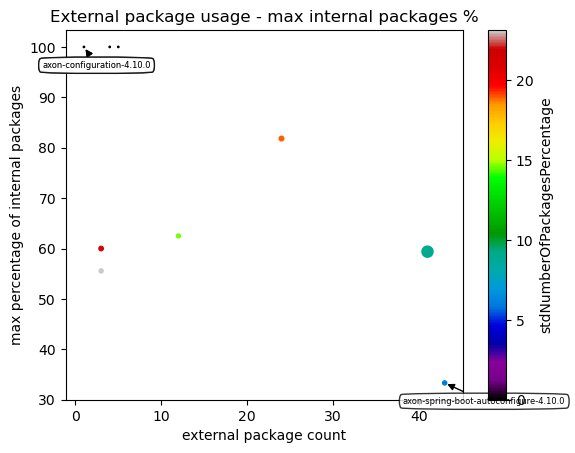

In [46]:
if external_package_usage_aggregated.empty:
    print("No data to plot")
else:
    plot.figure();
    axes = external_package_usage_aggregated.plot(
        kind='scatter',
        title='External package usage - max internal packages %', 
        x='numberOfExternalPackages',
        y='maxNumberOfPackagesPercentage',
        s='artifactPackages',
        c='stdNumberOfPackagesPercentage',
        xlabel='external package count',
        ylabel='max percentage of internal packages',
        cmap=main_color_map,
    )

    # Annotate the largest artifact with the highest number of external packages and max number of packages in percentage
    annotation_index = index_of_sorted(highest=['numberOfExternalPackages','maxNumberOfPackagesPercentage'], data_frame=external_package_usage_aggregated)
    annotate_plot(external_package_usage_aggregated, annotation_index)


    # Annotate the largest artifact with the lowest number of external packages and the highest max number of packages in percentage
    annotation_index = index_of_sorted(highest=['maxNumberOfPackagesPercentage'], data_frame=external_package_usage_aggregated)
    annotate_plot(external_package_usage_aggregated, annotation_index)

    # Annotate the largest artifact with the lowest number of external packages and max number of packages in percentage
    annotation_index = index_of_sorted(highest=[], data_frame=external_package_usage_aggregated)
    annotate_plot(external_package_usage_aggregated, annotation_index)

    plot.show()

#### Table 13 Chart 2 - External package usage - median percentage of internal types

This chart shows per artifact the median (0.5 percentile) of internal packages (compared to all packages in that artifact) that use one specific external package. 

**Example:** One artifact might use 9 external packages where 3 of them are used in 1 internal package, 3 of them are used in 2 package and the last 3 ones are used in 3 packages. So for this artifact there will be a point at x = 10 (external packages used by the artifact) and 2 (median internal packages). Instead of the count the percentage of internal packages compared to all packages in that artifact is used to get a normalized plot.

<Figure size 640x480 with 0 Axes>

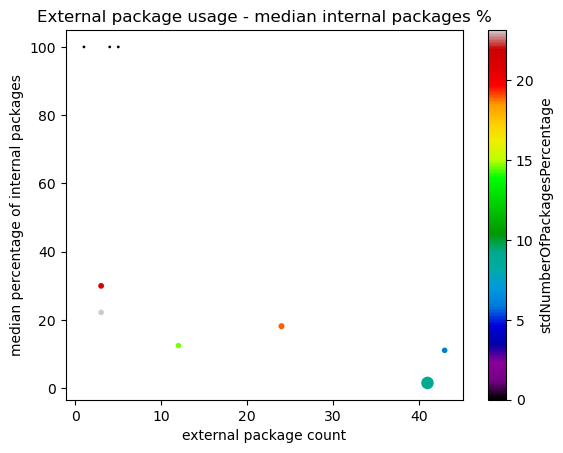

In [47]:
if external_package_usage_aggregated.empty:
    print("No data to plot")
else:
    plot.figure();
    axes = external_package_usage_aggregated.plot(
        kind='scatter',
        title='External package usage - median internal packages %', 
        x='numberOfExternalPackages',
        y='medNumberOfPackagesPercentage',
        s='artifactPackages',
        c='stdNumberOfPackagesPercentage',
        xlabel='external package count',
        ylabel='median percentage of internal packages',
        cmap=main_color_map,
    )
    plot.show()

## Maven POMs


### Table 14 - Maven POMs and their declared dependencies

If Maven is used as for package and dependency management and a ".pom" file is included in the artifact, the following table shows the external dependencies that are declared there.

In [48]:
query_cypher_to_data_frame("../cypher/External_Dependencies/Maven_POMs_and_their_declared_dependencies.cypher")

,pom.artifactId,pom.name,scope,dependency.optional,dependentArtifact.group,dependentArtifact.name
0,axon-configuration,pom,provided,False,com.google.code.findbugs,jsr305
1,axon-configuration,pom,test,False,${project.groupId},axon-messaging
2,axon-configuration,pom,default,True,jakarta.annotation,jakarta.annotation-api
3,axon-configuration,pom,default,False,org.axonframework,axon-messaging
4,axon-configuration,pom,test,True,io.projectreactor,reactor-core
...,...,...,...,...,...,...
158,axon-test,pom,default,True,junit,junit
159,axon-tracing-opentelemetry,pom,provided,False,com.google.code.findbugs,jsr305
160,axon-tracing-opentelemetry,pom,default,False,${project.groupId},axon-messaging
161,axon-tracing-opentelemetry,pom,default,False,io.opentelemetry,opentelemetry-api


In [49]:
driver.close()